<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

test-balanced.csv    train-balanced-sarc.csv.gz
test-unbalanced.csv  train-balanced-sarcasm.csv


In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [8]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comment'], train_df['label'], random_state=17)

In [9]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', max_words = 200, max_font_size = 100, random_state = 17, width=800, height=400)

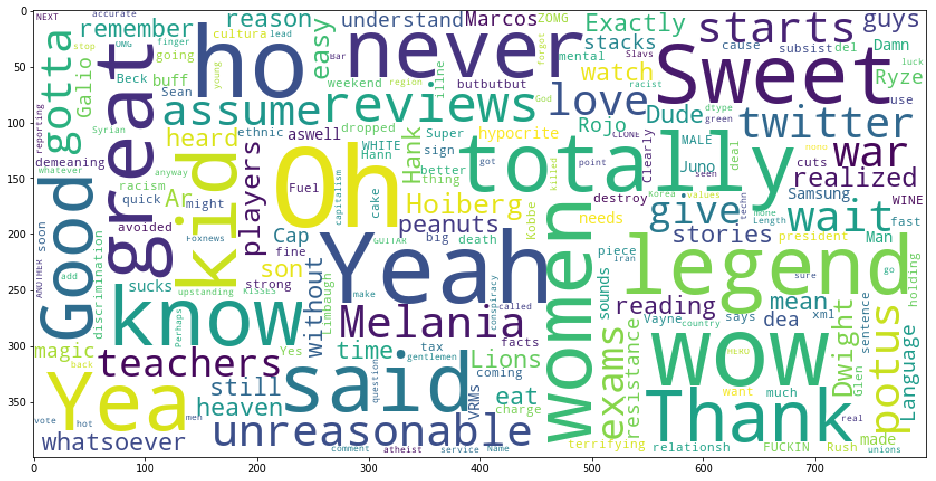

In [10]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud);

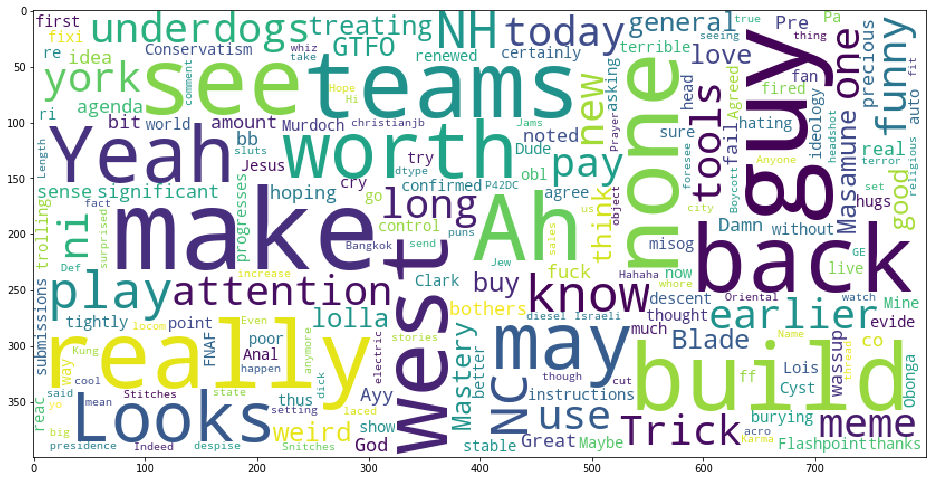

In [11]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment']))
plt.imshow(wordcloud);

In [12]:
sarcastic_users_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sarcastic_users_df.sort_values(by='sum', ascending=False).head(15)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [13]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)

In [14]:
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [15]:
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), ('logit', logit)])

In [16]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 50.6 s, sys: 1.95 s, total: 52.6 s
Wall time: 1min 27s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   34.8s finished


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tr... penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False))])

In [17]:
valid_pred = tfidf_logit_pipeline.predict(valid_texts)
accuracy_score(y_valid, valid_pred)

0.7238042850245752

In [ ]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions